# Joint Modeling end-to-end demo

Here we achieve the key goal of `blasé`: to make an end-to-end joint model for both the star and telluric spectrum.

In [1]:
%config Completer.use_jedi = False

In [2]:
import torch
from blase.emulator import (SparseLinearEmulator, 
                            SparseLogEmulator, 
                            ExtrinsicModel,
                            InstrumentalModel)
import matplotlib.pyplot as plt
from gollum.phoenix import PHOENIXSpectrum
from gollum.telluric import TelFitSpectrum
import numpy as np
from tqdm.notebook import tqdm
import os

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
    
%matplotlib inline
%config InlineBackend.figure_format='retina'

## Set the wavelength limits

In [3]:
wl_lo = 11_000-60
wl_hi = 11_180+60

## Read in Data

In [4]:
from muler.hpf import HPFSpectrum
import pandas as pd
import glob

In [5]:
df = pd.read_csv('../../../blimp/data/tables/001_goldilocks_dropbox_847x22_v1p0.csv')
df = df[df.OBJECT.str.contains('WASP_69')].reset_index()
target_fn = df.file_basename[12]

In [6]:
fns = glob.glob('/Volumes/pecos/HPF/Dropbox/**/*.spectra.fits', recursive=True)

In [7]:
absolute_path = [fn for fn in fns if target_fn in fn][0]

In [8]:
rawdata = HPFSpectrum(file=absolute_path, order=20)
data = rawdata.sky_subtract(method='vector').trim_edges((8, 2040)).deblaze().normalize()

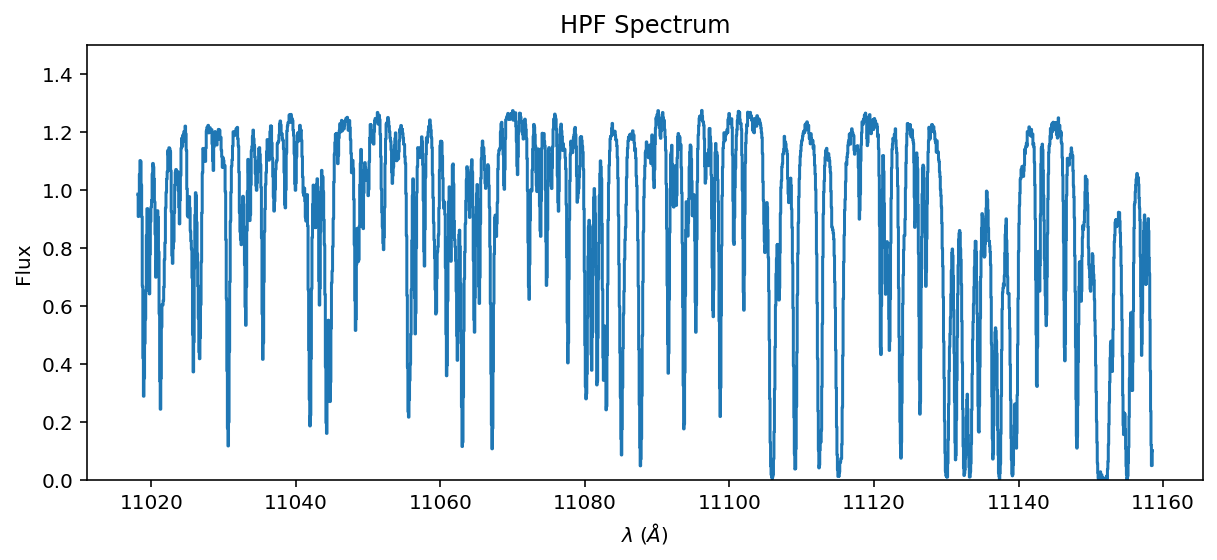

In [9]:
ax = data.plot()
ax.set_ylim(0, 1.5);

## Read in a precomputed synthetic stellar spectrum

In [10]:
stellar_spectrum = PHOENIXSpectrum(teff=4700, logg=4.5, wl_lo=wl_lo, wl_hi=wl_hi)
stellar_spectrum = stellar_spectrum.divide_by_blackbody()
stellar_spectrum = stellar_spectrum.normalize()
continuum_fit = stellar_spectrum.fit_continuum(polyorder=5)
stellar_spectrum = stellar_spectrum.divide(continuum_fit, handle_meta="ff")

## Read in a precomputed synthetic telluric spectrum

In [11]:
fn = '/Volumes/pecos/libraries/raw/telfit/grid_v1p0/telfit_800_1300nm_temp270_hum055.txt'

In [12]:
telluric_spectrum_full = TelFitSpectrum(path=fn).air_to_vacuum()

In [13]:
mask = (telluric_spectrum_full.wavelength.value > wl_lo) & (telluric_spectrum_full.wavelength.value < wl_hi)

In [14]:
telluric_spectrum = telluric_spectrum_full.apply_boolean_mask(mask)

Great! Let's clone the telluric spectrum with the LogEmulator.

In [15]:
telluric_wl = telluric_spectrum.wavelength.value
telluric_flux = telluric_spectrum.flux.value
telluric_flux = np.abs(telluric_flux)
telluric_lnflux = np.log(telluric_flux)

Below about -15 in log space, the flux becomes dominated by numerical artifacts.  That's okay, we will never perceive flux that is less than a ten-millionth of the continuum, so we can simply chop it off.  

In [16]:
telluric_lnflux[telluric_lnflux < -15] = -15

In [17]:
emulator = SparseLogEmulator(telluric_wl, telluric_lnflux, wing_cut_pixels=6000, prominence=0.01)

Initializing a sparse model with 235 spectral lines


## Overplot

(11060.0, 11120.0)

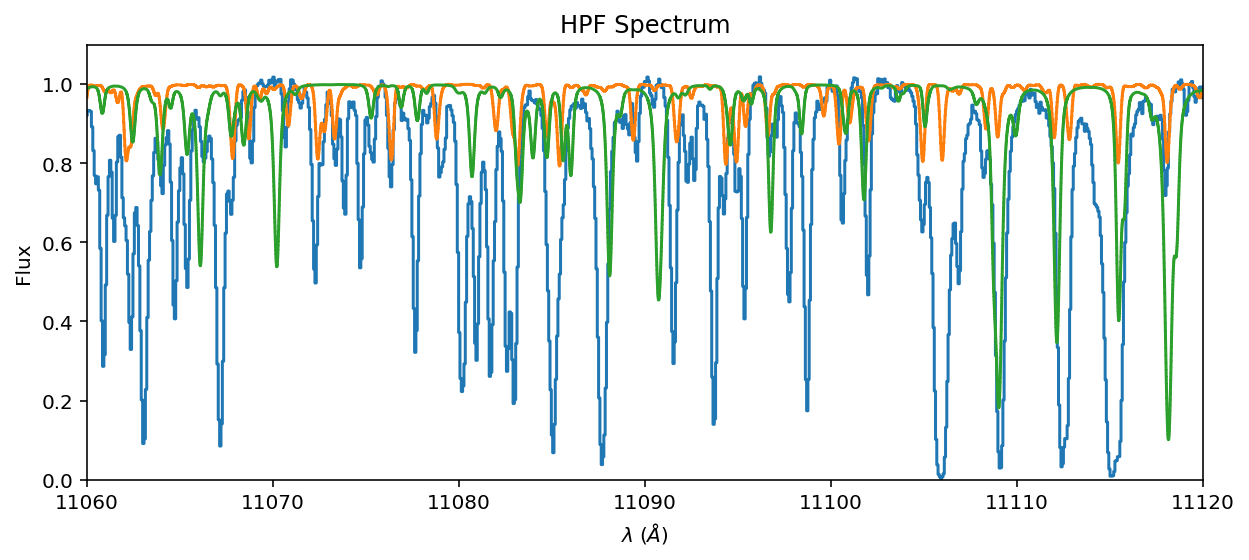

In [18]:
ax = (data*0.8).plot(ylo=0, yhi=1.1);
stellar_spectrum.rotationally_broaden(2.1).rv_shift(23.0).instrumental_broaden().plot(ax=ax)
telluric_spectrum.air_to_vacuum().instrumental_broaden().plot(ax=ax)
ax.set_xlim(11_060, 11_120)

## Train the emulator.

In [19]:
emulator.lam_centers.requires_grad = False
emulator.amplitudes.requires_grad = True
emulator.sigma_widths.requires_grad = True
emulator.gamma_widths.requires_grad = True

In [20]:
emulator.optimize(epochs=100)

Training Loss: 0.00029502: 100%|██████████████| 100/100 [01:33<00:00,  1.07it/s]


In [21]:
with torch.no_grad():
    telluric_post = emulator.forward().numpy()

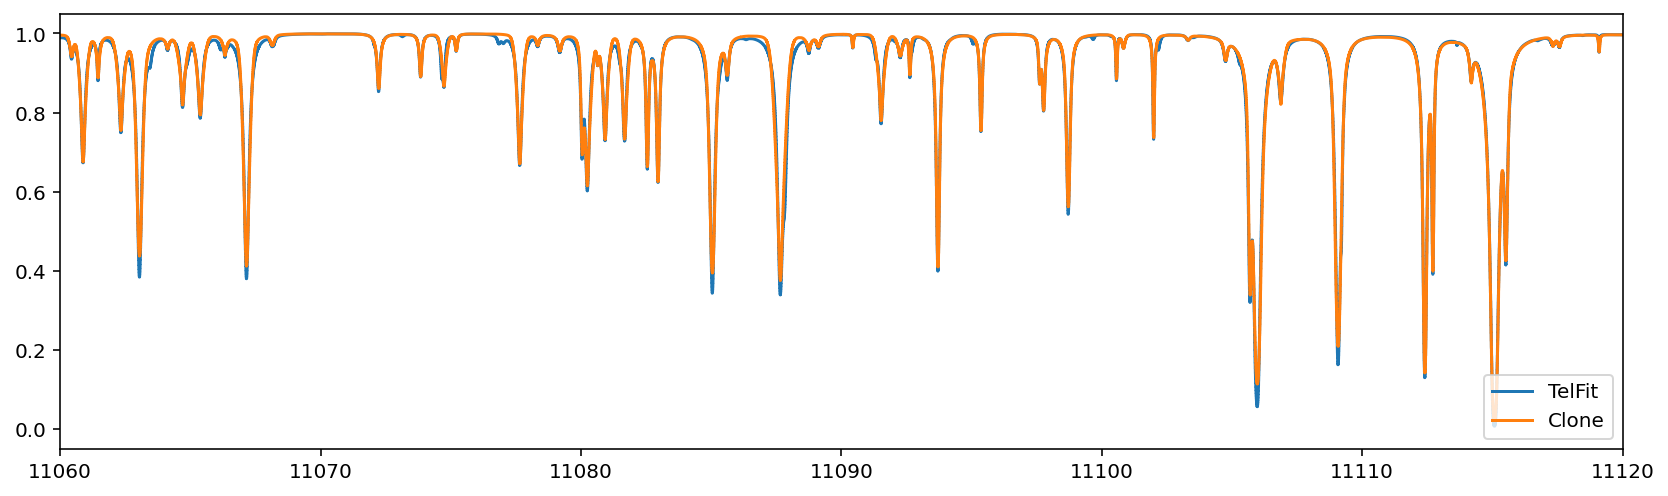

In [22]:
plt.figure(figsize=(14,4))
plt.step(telluric_wl, telluric_flux, label='TelFit')
plt.step(telluric_wl, telluric_post, label='Clone')
plt.xlim(11_060, 11_120)
plt.legend(loc='lower right');

In [23]:
residual = telluric_flux-telluric_post

In [24]:
residual_mask = (telluric_wl >11_060) & (telluric_wl<11_120)

In [25]:
residual=residual[residual_mask]

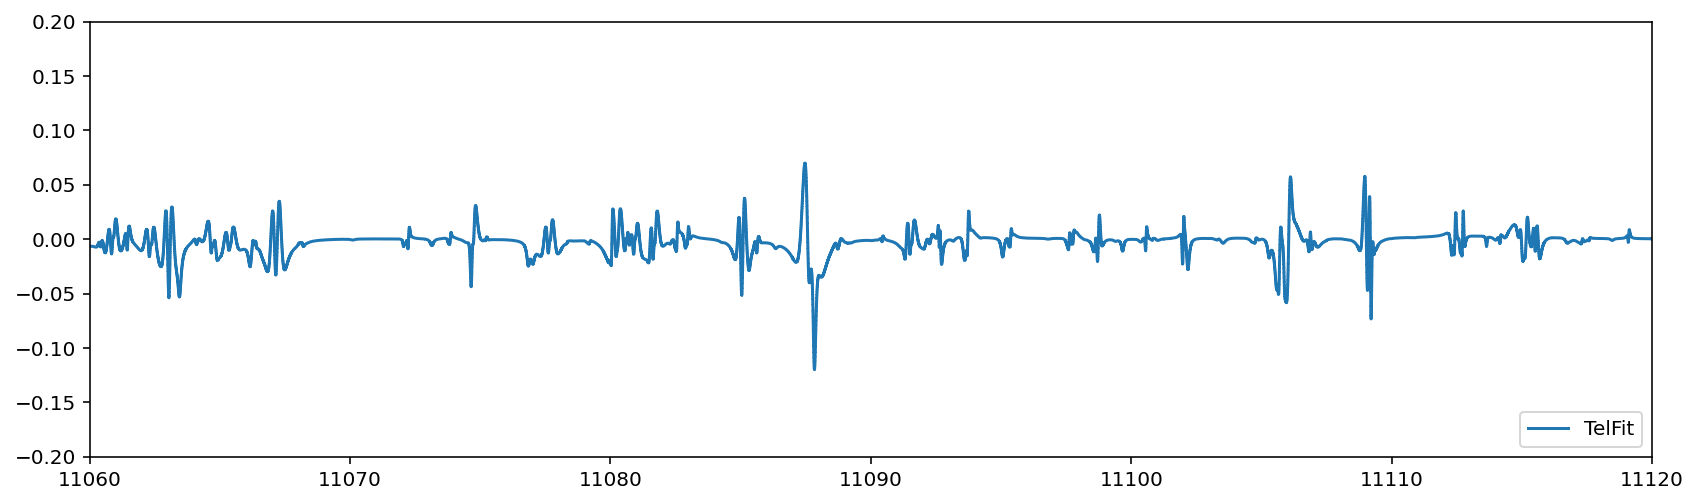

In [26]:
plt.figure(figsize=(14,4))
plt.step(telluric_wl, telluric_flux-telluric_post,ms=1, label='TelFit')
plt.xlim(11_060, 11_120)
plt.ylim(-0.2, 0.2)
plt.legend(loc='lower right');

In [27]:
np.std(telluric_flux)/np.std(residual)

21.261051700490484

In [28]:
np.std(residual)

0.011793361217155105

## Clone the stellar model

In [29]:
stellar_spectrum.wavelength.value.shape

(14999,)

In [30]:
stellar_wl = stellar_spectrum.wavelength.value
stellar_flux = stellar_spectrum.flux.value
stellar_emulator = SparseLinearEmulator(stellar_wl, 
                             stellar_flux, 
                             wing_cut_pixels=6000, prominence=0.01)

Initializing a sparse model with 440 spectral lines


In [31]:
stellar_emulator.optimize()

Training Loss: 0.00011602: 100%|██████████████| 100/100 [02:33<00:00,  1.54s/it]


In [32]:
with torch.no_grad():
    stellar_post = stellar_emulator.forward().numpy()

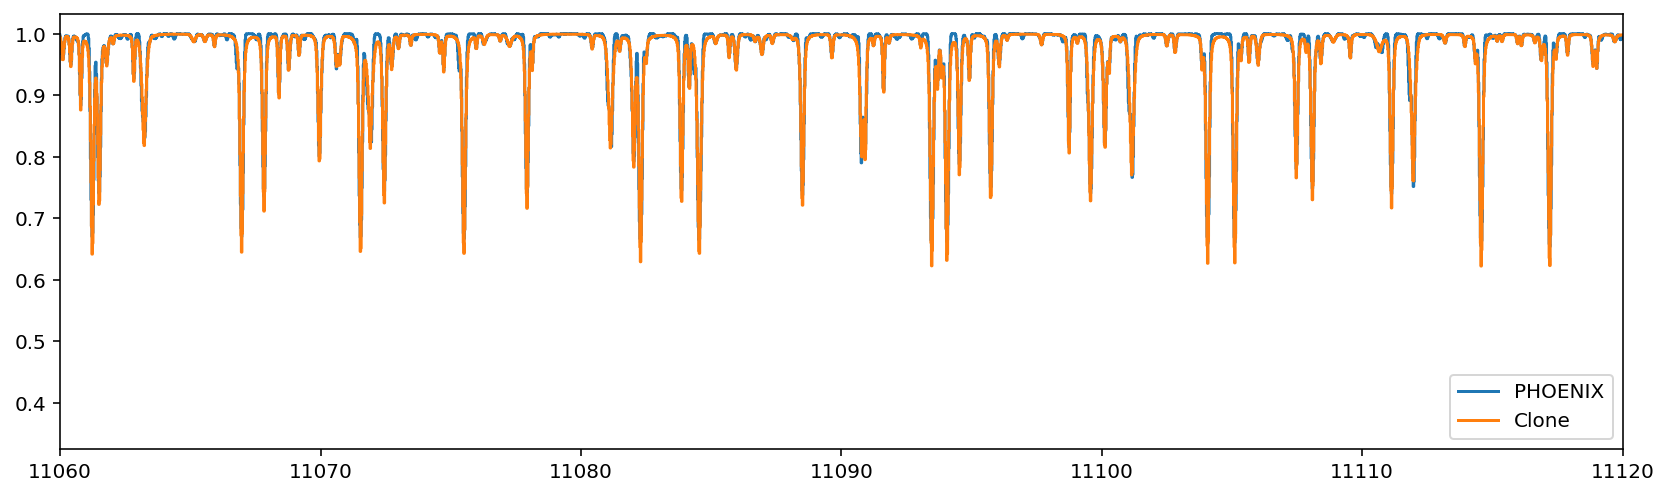

In [33]:
plt.figure(figsize=(14,4))
plt.step(stellar_wl, stellar_flux, label='PHOENIX')
plt.step(stellar_wl, stellar_post, label='Clone')
plt.xlim(11_060, 11_120)
plt.legend(loc='lower right');

In [34]:
np.std(stellar_flux)

0.07175267224813513

In [35]:
resid = stellar_flux-stellar_post

In [36]:
resid_mask = (stellar_wl >11_060) & (stellar_wl<11_120)

In [37]:
resid = resid[resid_mask]

In [38]:
np.std(resid)

0.009456778343276738

## Tune the extrinsic model

In [39]:
ext_model = ExtrinsicModel(stellar_wl)

In [40]:
with torch.no_grad():
    ext_model.ln_vsini *=0 
    ext_model.ln_vsini += np.log(1.1)

    stellar_emulator.radial_velocity *=0
    stellar_emulator.radial_velocity +=23

In [41]:
with torch.no_grad():
    stellar_shift = stellar_emulator.forward()
    conv_flux = ext_model.forward(stellar_shift)

In [42]:
conv_flux.shape

torch.Size([14999])

## Combine the two emulators

The telluric emulator has much finer sampling than the stellar emulator.  Let's spot-check if that makes a difference:

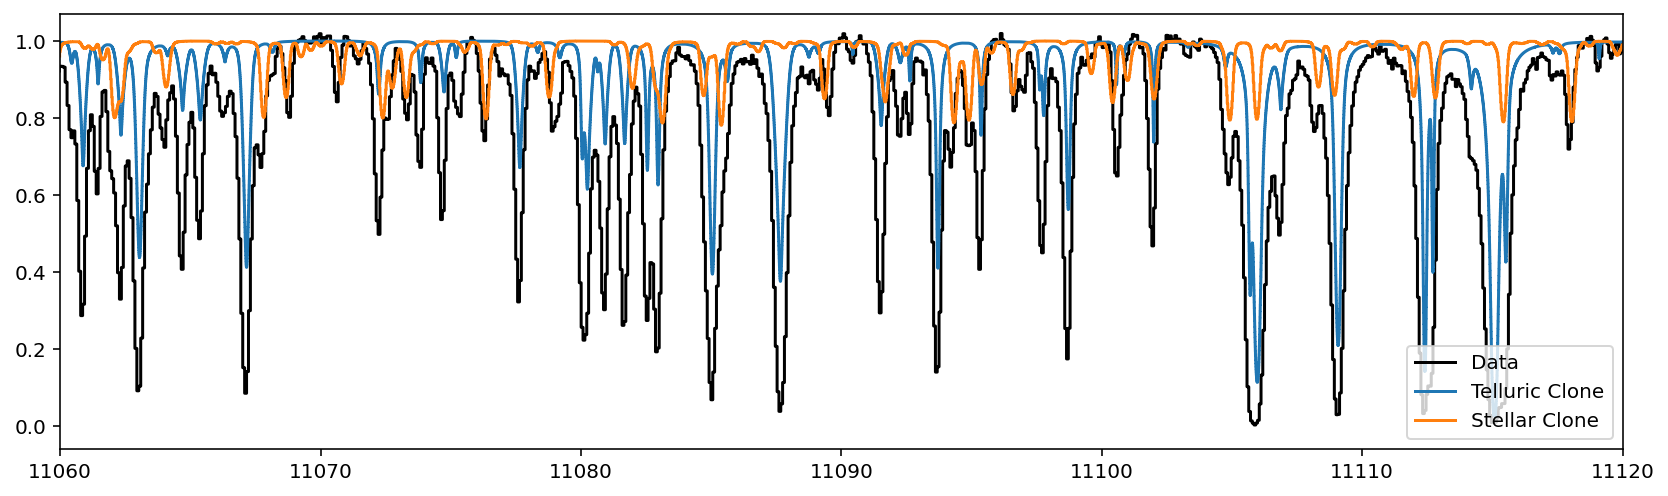

In [43]:
plt.figure(figsize=(14,4))

plt.step(data.wavelength, (data*0.8).flux, label='Data', color='k')

plt.step(telluric_wl, telluric_post, label='Telluric Clone')

plt.step(stellar_wl, conv_flux, label='Stellar Clone')
plt.xlim(11_060, 11_120)
plt.legend(loc='lower right');

Ok! We have two emulators, and now need to combine them.  The problem is that they have different shapes:

In [44]:
telluric_post.shape, conv_flux.shape

((119402,), torch.Size([14999]))

### Resample the telluric model to the stellar native wavelength coordinates

In [45]:
dummy_flux = stellar_flux*0.0

In [46]:
init_state_dict = emulator.state_dict()

In [47]:
resamp_Telluric_emulator = SparseLogEmulator(wl_native=stellar_wl, 
                                             lnflux_native=dummy_flux, wing_cut_pixels=6000, 
                                             init_state_dict=init_state_dict)

Initializing a sparse model with 235 spectral lines


In [48]:
resamp_Telluric_emulator.state_dict().keys()

odict_keys(['lam_centers', 'amplitudes', 'sigma_widths', 'gamma_widths', 'a_coeff', 'b_coeff', 'c_coeff', 'radial_velocity'])

In [49]:
with torch.no_grad():
    resamp_telluric_flux = resamp_Telluric_emulator.forward()

In [50]:
resamp_telluric_flux.shape 

torch.Size([14999])

Amazing!

## Compute the joint model

In [51]:
M_joint_flux = conv_flux * resamp_telluric_flux

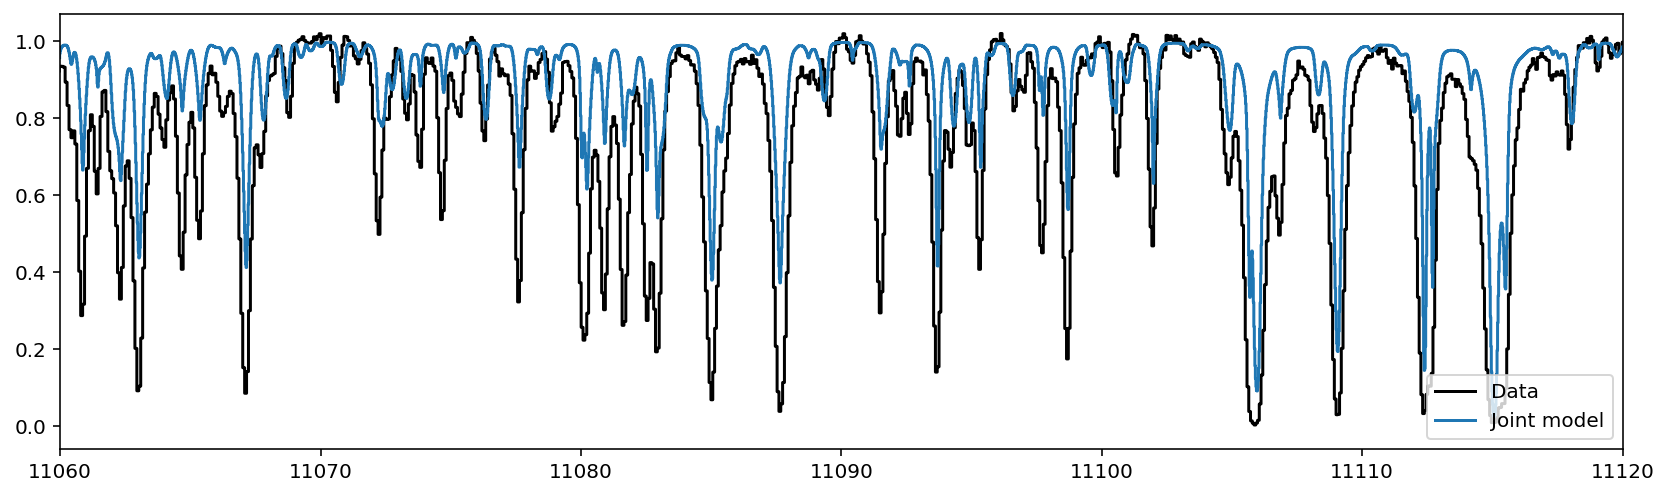

In [52]:
plt.figure(figsize=(14,4))

plt.step(data.wavelength, (data*0.8).flux, label='Data', color='k')

plt.step(stellar_wl, M_joint_flux, label='Joint model')
plt.xlim(11_060, 11_120)
plt.legend(loc='lower right');

Yay! Let's refine the joint model with an instrument model!

## Instrument model and resampling

In [53]:
from tqdm import trange
import torch.optim as optim
from torch import nn

In [54]:
from blase.emulator import InstrumentalModel

model = InstrumentalModel(
    data.spectral_axis.bin_edges.value.astype(np.float64), stellar_wl
)
model.to(device)

InstrumentalModel(
  (linear_model): Linear(in_features=15, out_features=1, bias=True)
)

In [69]:
peak_scalar = np.nanpercentile(data.flux, 98)
data = data.divide(peak_scalar, handle_meta='ff')

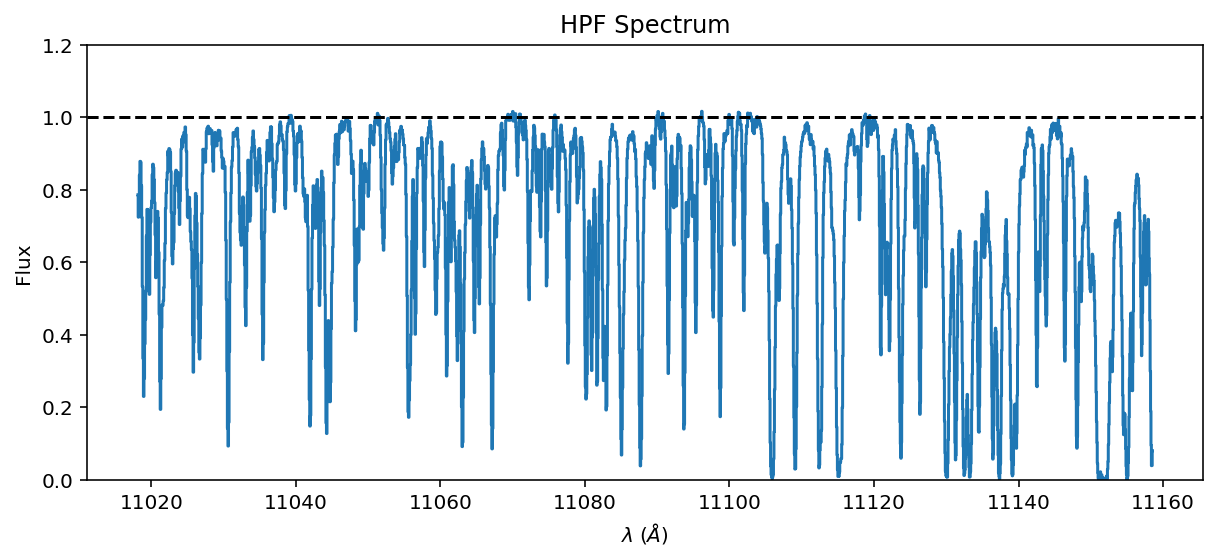

In [74]:
ax = data.plot(ylo=0)
ax.axhline(1.0, color='k', linestyle='dashed')

In [75]:
data_target = torch.tensor(
    data.flux.value.astype(np.float64), device=device, dtype=torch.float64
)

In [76]:
data_wavelength = torch.tensor(
    data.wavelength.value.astype(np.float64), device=device, dtype=torch.float64
)

In [77]:
loss_fn = nn.MSELoss(reduction="sum")

In [78]:
import copy

In [79]:
optimizer = optim.Adam(
    list(filter(lambda p: p.requires_grad, ext_model.parameters()))
    + list(filter(lambda p: p.requires_grad, stellar_emulator.parameters()))
    + list(filter(lambda p: p.requires_grad, resamp_Telluric_emulator.parameters())),
    0.01,
    amsgrad=True,
)
n_epochs = 100
losses = []

with torch.no_grad():
    telluric_amplitude_init = copy.deepcopy(torch.exp(resamp_Telluric_emulator.amplitudes))
    stellar_amplitude_init = copy.deepcopy(torch.exp(stellar_emulator.amplitudes))

# Define the prior on the amplitude
def ln_prior(amplitude_vector, amplitude_init):
    """
    Prior for the amplitude vector
    """
    amplitude_difference = amplitude_init - torch.exp(amplitude_vector)
    return 0.5 * torch.sum((amplitude_difference ** 2) / (0.01 ** 2))

In [110]:
# We need uncertainty to be able to compute the posterior
# Assert fixed per-pixel uncertainty for now
per_pixel_uncertainty = torch.tensor(0.004, device=device, dtype=torch.float64)

In [111]:
t_iter = trange(n_epochs, desc="Training", leave=True)
for epoch in t_iter:
    resamp_Telluric_emulator.train()
    stellar_emulator.train()
    ext_model.train()
    model.train()
    tellurics = resamp_Telluric_emulator.forward()
    star = stellar_emulator.forward()
    conv_star = ext_model.forward(star)
    joint_model = conv_star * tellurics
    yhat = model.forward(joint_model)
    loss = loss_fn(yhat / per_pixel_uncertainty, data_target / per_pixel_uncertainty)
    loss += ln_prior(resamp_Telluric_emulator.amplitudes, telluric_amplitude_init)
    loss += ln_prior(stellar_emulator.amplitudes, stellar_amplitude_init)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    t_iter.set_description("Training Loss: {:0.8f}".format(loss.item()))

Training Loss: 126483.28547444: 100%|█████████| 100/100 [04:10<00:00,  2.51s/it]


In [112]:
with torch.no_grad():
    tellurics = resamp_Telluric_emulator.forward()
    star = stellar_emulator.forward()
    conv_star = ext_model.forward(star)
    joint_model = conv_star * tellurics
    yhat = model.forward(joint_model)
    stellar_inst = model.forward(conv_star)
    telluric_inst = model.forward(tellurics)

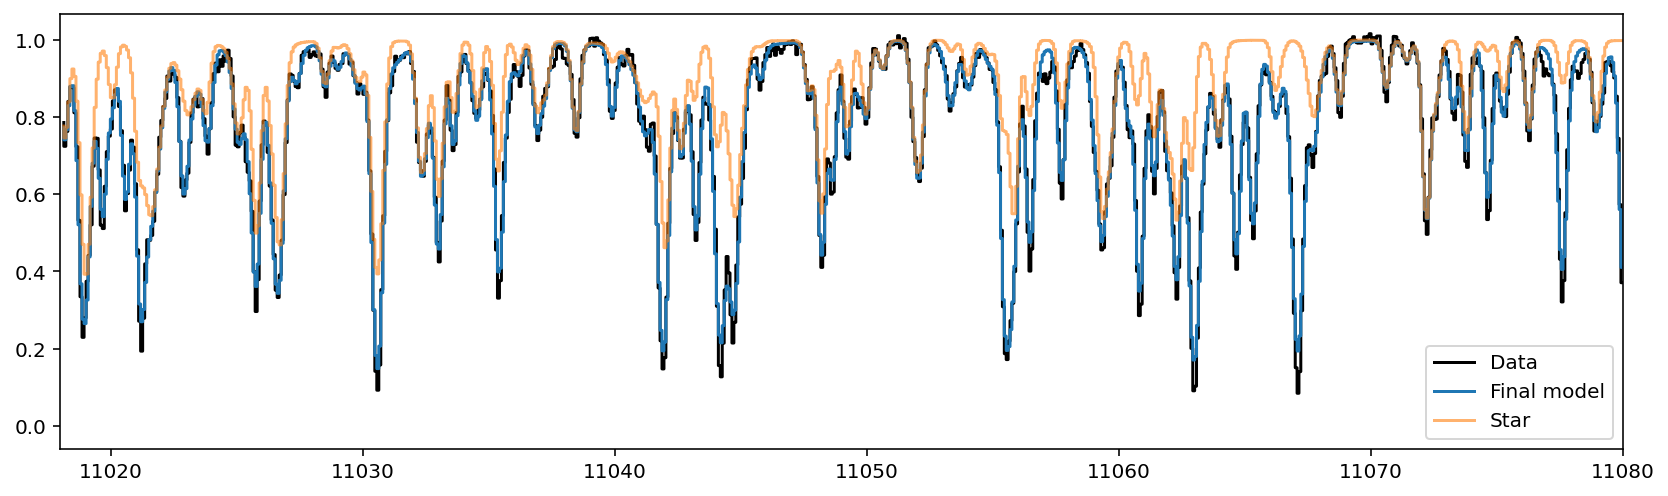

In [122]:
plt.figure(figsize=(14,4))

plt.step(data.wavelength, data_target, label='Data', color='k', lw=1.5)

#plt.step(stellar_wl, joint_model, label='Joint model')

plt.step(data.wavelength, yhat, label='Final model', alpha=1.0, lw=1.5)

plt.step(data.wavelength, stellar_inst, label='Star', alpha=0.6, lw=1.5)
#plt.step(data.wavelength, telluric_inst, label='Tellurics', alpha=0.6, lw=1.5)

#plt.xlim(11_060, 11_120)
plt.xlim(11_018, 11_080)

plt.legend(loc='lower right');

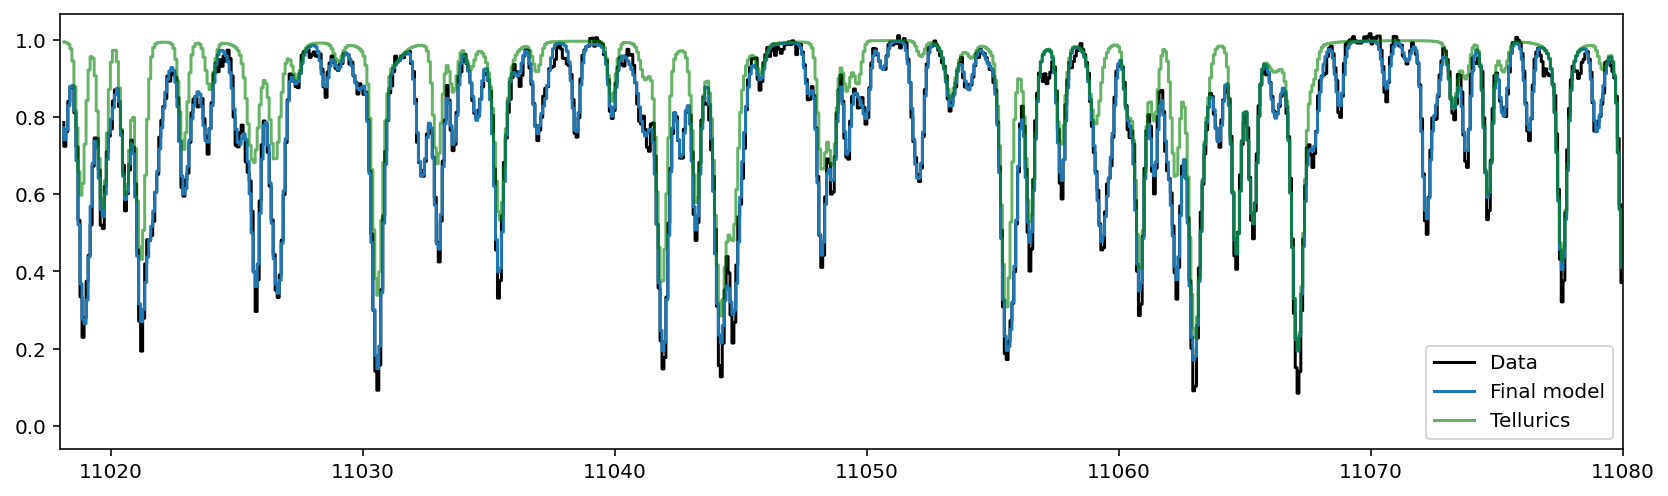

In [124]:
plt.figure(figsize=(14,4))

plt.step(data.wavelength, data_target, label='Data', color='k', lw=1.5)
#plt.step(stellar_wl, joint_model, label='Joint model')
plt.step(data.wavelength, yhat, label='Final model', alpha=1.0, lw=1.5)

#plt.step(data.wavelength, stellar_inst, label='Star', alpha=0.6, lw=1.5)
plt.step(data.wavelength, telluric_inst, label='Tellurics', alpha=0.6, lw=1.5, color='g')

#plt.xlim(11_060, 11_120)
plt.xlim(11_018, 11_080)

plt.legend(loc='lower right');

Yay! It works end-to-end!